# LSTM - vanilla

In [102]:
best_model = "best_model3.pt"

## Load and prepare data

In [103]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [104]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


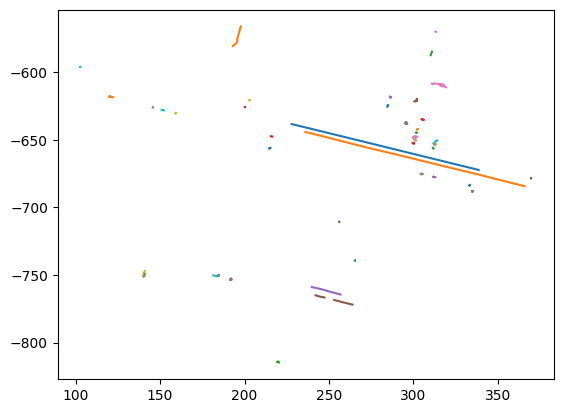

In [105]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [106]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [107]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [108]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=512, output_dim=60*2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # Process through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Extract final hidden state
        features = lstm_out[:, -1, :]
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [113]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [117]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=6, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 9.07
        # lr = 0.01 => 9.18
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [118]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:14<23:40, 14.35s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 1.1653 | Val MSE 0.5066 | Val MAE 2.7466 | Val MSE 24.8226
Sample pred first 3 steps: [[ 0.00162697 -0.00342252]
 [-0.02374903  0.00052806]
 [-0.01845755  0.00072932]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 0.506584


Epoch:   2%|▏         | 2/100 [00:23<18:05, 11.08s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.4330 | Val MSE 0.4670 | Val MAE 2.9459 | Val MSE 22.8822
Validation improved: 0.506584 -> 0.466984


Epoch:   3%|▎         | 3/100 [00:32<16:44, 10.36s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.4216 | Val MSE 0.3758 | Val MAE 2.3756 | Val MSE 18.4153
Validation improved: 0.466984 -> 0.375822


Epoch:   4%|▍         | 4/100 [00:41<15:32,  9.71s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.3871 | Val MSE 0.3401 | Val MAE 2.1446 | Val MSE 16.6652
Validation improved: 0.375822 -> 0.340107


Epoch:   5%|▌         | 5/100 [00:49<14:32,  9.18s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.3562 | Val MSE 0.3022 | Val MAE 1.9673 | Val MSE 14.8073
Validation improved: 0.340107 -> 0.302190


Epoch:   6%|▌         | 6/100 [00:58<14:22,  9.17s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.3307 | Val MSE 0.3027 | Val MAE 2.0551 | Val MSE 14.8324
Sample pred first 3 steps: [[-0.00097162  0.00249931]
 [-0.00562494  0.00646765]
 [-0.00781153  0.01737292]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:   7%|▋         | 7/100 [01:07<13:52,  8.95s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.3167 | Val MSE 0.2717 | Val MAE 1.8637 | Val MSE 13.3130
Validation improved: 0.302190 -> 0.271695


Epoch:   8%|▊         | 8/100 [01:15<13:35,  8.86s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.2968 | Val MSE 0.2491 | Val MAE 1.8892 | Val MSE 12.2066
Validation improved: 0.271695 -> 0.249114


Epoch:   9%|▉         | 9/100 [01:25<13:55,  9.18s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.2833 | Val MSE 0.2777 | Val MAE 2.0518 | Val MSE 13.6093


Epoch:  10%|█         | 10/100 [01:34<13:26,  8.96s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.2721 | Val MSE 0.2677 | Val MAE 1.9309 | Val MSE 13.1190


Epoch:  11%|█         | 11/100 [01:42<12:49,  8.64s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.2565 | Val MSE 0.2497 | Val MAE 1.9535 | Val MSE 12.2365
Sample pred first 3 steps: [[ 0.00555507 -0.00320039]
 [ 0.01022996  0.00017408]
 [ 0.01509093 -0.01230489]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  12%|█▏        | 12/100 [01:50<12:29,  8.52s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.2581 | Val MSE 0.2220 | Val MAE 1.7437 | Val MSE 10.8802
Validation improved: 0.249114 -> 0.222045


Epoch:  13%|█▎        | 13/100 [01:59<12:23,  8.55s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.2432 | Val MSE 0.2118 | Val MAE 1.6958 | Val MSE 10.3771
Validation improved: 0.222045 -> 0.211778


Epoch:  14%|█▍        | 14/100 [02:08<12:32,  8.75s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.2399 | Val MSE 0.2050 | Val MAE 1.5671 | Val MSE 10.0431
Validation improved: 0.211778 -> 0.204961


Epoch:  15%|█▌        | 15/100 [02:17<12:31,  8.84s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.2341 | Val MSE 0.2107 | Val MAE 1.6819 | Val MSE 10.3228


Epoch:  16%|█▌        | 16/100 [02:25<12:10,  8.69s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.2306 | Val MSE 0.2043 | Val MAE 1.6024 | Val MSE 10.0117
Sample pred first 3 steps: [[-0.0021414  -0.00233122]
 [-0.00609714 -0.00316714]
 [-0.0081955   0.00189435]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.204961 -> 0.204322


Epoch:  17%|█▋        | 17/100 [02:34<11:58,  8.66s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.2247 | Val MSE 0.1954 | Val MAE 1.5586 | Val MSE 9.5740
Validation improved: 0.204322 -> 0.195389


Epoch:  18%|█▊        | 18/100 [02:42<11:40,  8.54s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.2205 | Val MSE 0.2027 | Val MAE 1.5969 | Val MSE 9.9343


Epoch:  19%|█▉        | 19/100 [02:50<11:08,  8.25s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.2203 | Val MSE 0.2122 | Val MAE 1.7014 | Val MSE 10.3979


Epoch:  20%|██        | 20/100 [02:58<11:09,  8.37s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.2183 | Val MSE 0.2060 | Val MAE 1.5896 | Val MSE 10.0939


Epoch:  21%|██        | 21/100 [03:07<11:06,  8.44s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.2149 | Val MSE 0.2058 | Val MAE 1.6486 | Val MSE 10.0831
Sample pred first 3 steps: [[-0.00637683  0.00298845]
 [-0.00474085  0.00022242]
 [-0.01070057  0.00377123]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [03:15<10:51,  8.36s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.2146 | Val MSE 0.1870 | Val MAE 1.5249 | Val MSE 9.1612
Validation improved: 0.195389 -> 0.186964


Epoch:  23%|██▎       | 23/100 [03:25<11:19,  8.83s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.2097 | Val MSE 0.1946 | Val MAE 1.4939 | Val MSE 9.5349


Epoch:  24%|██▍       | 24/100 [03:34<11:25,  9.02s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.2097 | Val MSE 0.1889 | Val MAE 1.5074 | Val MSE 9.2573


Epoch:  25%|██▌       | 25/100 [03:44<11:23,  9.12s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.2053 | Val MSE 0.1895 | Val MAE 1.5394 | Val MSE 9.2877


Epoch:  26%|██▌       | 26/100 [03:53<11:22,  9.22s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.2054 | Val MSE 0.1889 | Val MAE 1.4659 | Val MSE 9.2540
Sample pred first 3 steps: [[ 0.00054916  0.00248035]
 [-0.00266217 -0.0002655 ]
 [-0.00440503 -0.00480923]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  27%|██▋       | 27/100 [04:02<11:03,  9.08s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.2048 | Val MSE 0.1902 | Val MAE 1.5369 | Val MSE 9.3219


Epoch:  28%|██▊       | 28/100 [04:10<10:32,  8.79s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.2051 | Val MSE 0.2046 | Val MAE 1.6296 | Val MSE 10.0236


Epoch:  29%|██▉       | 29/100 [04:18<10:05,  8.53s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.2016 | Val MSE 0.1799 | Val MAE 1.4508 | Val MSE 8.8155
Validation improved: 0.186964 -> 0.179909


Epoch:  30%|███       | 30/100 [04:28<10:24,  8.92s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.1983 | Val MSE 0.1853 | Val MAE 1.4817 | Val MSE 9.0798


Epoch:  31%|███       | 31/100 [04:38<10:42,  9.31s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.1965 | Val MSE 0.1967 | Val MAE 1.5450 | Val MSE 9.6371
Sample pred first 3 steps: [[ 0.00351601  0.00082167]
 [ 0.00215176 -0.00260893]
 [ 0.00315632 -0.00198622]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  32%|███▏      | 32/100 [04:48<10:49,  9.56s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.1980 | Val MSE 0.1810 | Val MAE 1.4311 | Val MSE 8.8704


Epoch:  33%|███▎      | 33/100 [05:00<11:29, 10.29s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.1946 | Val MSE 0.1870 | Val MAE 1.4513 | Val MSE 9.1627


Epoch:  34%|███▍      | 34/100 [05:10<11:17, 10.26s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.1937 | Val MSE 0.1893 | Val MAE 1.5010 | Val MSE 9.2738


Epoch:  35%|███▌      | 35/100 [05:21<11:20, 10.46s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.1948 | Val MSE 0.1915 | Val MAE 1.5019 | Val MSE 9.3826


Epoch:  36%|███▌      | 36/100 [05:32<11:08, 10.45s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.1906 | Val MSE 0.1813 | Val MAE 1.4710 | Val MSE 8.8837
Sample pred first 3 steps: [[-0.00019868 -0.00223924]
 [ 0.00124622 -0.00321241]
 [ 0.002554   -0.00405732]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [05:42<11:03, 10.53s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.1926 | Val MSE 0.1810 | Val MAE 1.4422 | Val MSE 8.8671


Epoch:  38%|███▊      | 38/100 [05:52<10:39, 10.32s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.1892 | Val MSE 0.1862 | Val MAE 1.4539 | Val MSE 9.1218


Epoch:  39%|███▉      | 39/100 [06:02<10:27, 10.28s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.1886 | Val MSE 0.1850 | Val MAE 1.3959 | Val MSE 9.0646


Epoch:  40%|████      | 40/100 [06:12<10:12, 10.20s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.1871 | Val MSE 0.1808 | Val MAE 1.4000 | Val MSE 8.8586


Epoch:  41%|████      | 41/100 [06:23<10:01, 10.19s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.1870 | Val MSE 0.1748 | Val MAE 1.3834 | Val MSE 8.5669
Sample pred first 3 steps: [[ 0.00142695 -0.00124125]
 [ 0.00520803 -0.00156315]
 [ 0.00374338 -0.00288933]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.179909 -> 0.174835


Epoch:  42%|████▏     | 42/100 [06:32<09:44, 10.08s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.1842 | Val MSE 0.1789 | Val MAE 1.4032 | Val MSE 8.7685


Epoch:  43%|████▎     | 43/100 [06:42<09:25,  9.92s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.1826 | Val MSE 0.1846 | Val MAE 1.4684 | Val MSE 9.0441


Epoch:  44%|████▍     | 44/100 [06:51<09:06,  9.75s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.1822 | Val MSE 0.1783 | Val MAE 1.4241 | Val MSE 8.7386


Epoch:  45%|████▌     | 45/100 [07:02<09:03,  9.88s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.1828 | Val MSE 0.1765 | Val MAE 1.3818 | Val MSE 8.6471


Epoch:  46%|████▌     | 46/100 [07:13<09:12, 10.23s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.1812 | Val MSE 0.1732 | Val MAE 1.3870 | Val MSE 8.4859
Sample pred first 3 steps: [[-0.00140819 -0.00061303]
 [-0.00115361  0.000326  ]
 [-0.0023686  -0.00198328]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.174835 -> 0.173182


Epoch:  47%|████▋     | 47/100 [07:23<08:59, 10.18s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.1819 | Val MSE 0.1712 | Val MAE 1.3792 | Val MSE 8.3880
Validation improved: 0.173182 -> 0.171183


Epoch:  48%|████▊     | 48/100 [07:33<08:49, 10.18s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1802 | Val MSE 0.1731 | Val MAE 1.3957 | Val MSE 8.4837


Epoch:  49%|████▉     | 49/100 [07:43<08:36, 10.13s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.1811 | Val MSE 0.1728 | Val MAE 1.3707 | Val MSE 8.4668


Epoch:  50%|█████     | 50/100 [07:53<08:22, 10.05s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.1780 | Val MSE 0.1720 | Val MAE 1.3421 | Val MSE 8.4296


Epoch:  51%|█████     | 51/100 [08:03<08:12, 10.04s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.1781 | Val MSE 0.1739 | Val MAE 1.3617 | Val MSE 8.5228
Sample pred first 3 steps: [[ 0.0005227   0.00100617]
 [-0.00097467  0.0017046 ]
 [-0.00200172  0.00279072]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  52%|█████▏    | 52/100 [08:12<07:57,  9.95s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.1772 | Val MSE 0.1744 | Val MAE 1.3625 | Val MSE 8.5458


Epoch:  53%|█████▎    | 53/100 [08:22<07:45,  9.90s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.1774 | Val MSE 0.1737 | Val MAE 1.3666 | Val MSE 8.5095


Epoch:  54%|█████▍    | 54/100 [08:32<07:38,  9.96s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.1744 | Val MSE 0.1706 | Val MAE 1.3464 | Val MSE 8.3592
Validation improved: 0.171183 -> 0.170597


Epoch:  55%|█████▌    | 55/100 [08:42<07:27,  9.95s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.1746 | Val MSE 0.1715 | Val MAE 1.3512 | Val MSE 8.4032


Epoch:  56%|█████▌    | 56/100 [08:52<07:19,  9.99s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.1751 | Val MSE 0.1675 | Val MAE 1.3226 | Val MSE 8.2056
Sample pred first 3 steps: [[-7.5830612e-05  8.8612543e-04]
 [-1.9781291e-05  2.0324220e-03]
 [-5.8754813e-04  3.3171615e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.170597 -> 0.167461


Epoch:  57%|█████▋    | 57/100 [09:03<07:13, 10.07s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.1753 | Val MSE 0.1724 | Val MAE 1.3483 | Val MSE 8.4487


Epoch:  58%|█████▊    | 58/100 [09:11<06:41,  9.56s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.1747 | Val MSE 0.1678 | Val MAE 1.3330 | Val MSE 8.2236


Epoch:  59%|█████▉    | 59/100 [09:18<06:06,  8.93s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.1740 | Val MSE 0.1689 | Val MAE 1.3657 | Val MSE 8.2744


Epoch:  60%|██████    | 60/100 [09:26<05:41,  8.53s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.1731 | Val MSE 0.1707 | Val MAE 1.3298 | Val MSE 8.3662


Epoch:  61%|██████    | 61/100 [09:34<05:25,  8.35s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.1713 | Val MSE 0.1716 | Val MAE 1.3580 | Val MSE 8.4101
Sample pred first 3 steps: [[ 0.00017874 -0.00020307]
 [-0.00061065 -0.00036583]
 [-0.00062948  0.00013831]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  62%|██████▏   | 62/100 [09:42<05:11,  8.21s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.1707 | Val MSE 0.1721 | Val MAE 1.3530 | Val MSE 8.4351


Epoch:  63%|██████▎   | 63/100 [09:50<05:02,  8.17s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.1722 | Val MSE 0.1718 | Val MAE 1.3453 | Val MSE 8.4205


Epoch:  64%|██████▍   | 64/100 [09:58<04:56,  8.23s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.1713 | Val MSE 0.1689 | Val MAE 1.3251 | Val MSE 8.2780


Epoch:  65%|██████▌   | 65/100 [10:06<04:47,  8.22s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.1700 | Val MSE 0.1715 | Val MAE 1.3382 | Val MSE 8.4049


Epoch:  66%|██████▌   | 66/100 [10:14<04:36,  8.13s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.1705 | Val MSE 0.1735 | Val MAE 1.3522 | Val MSE 8.4994
Sample pred first 3 steps: [[-0.00093507  0.0004298 ]
 [-0.00044985  0.00044464]
 [-0.00112197  0.00013954]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  67%|██████▋   | 67/100 [10:22<04:23,  8.00s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.1721 | Val MSE 0.1722 | Val MAE 1.3494 | Val MSE 8.4376


Epoch:  68%|██████▊   | 68/100 [10:30<04:17,  8.03s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.1726 | Val MSE 0.1694 | Val MAE 1.3280 | Val MSE 8.3027


Epoch:  69%|██████▉   | 69/100 [10:38<04:05,  7.93s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.1687 | Val MSE 0.1675 | Val MAE 1.3240 | Val MSE 8.2076


Epoch:  70%|███████   | 70/100 [10:46<03:56,  7.89s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.1682 | Val MSE 0.1681 | Val MAE 1.3299 | Val MSE 8.2370


Epoch:  71%|███████   | 71/100 [10:54<03:50,  7.96s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.1687 | Val MSE 0.1688 | Val MAE 1.3391 | Val MSE 8.2707
Sample pred first 3 steps: [[-6.3228747e-04 -1.4748645e-04]
 [-1.0592761e-03  4.5267167e-05]
 [-1.7366875e-03  5.8172736e-05]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  72%|███████▏  | 72/100 [11:02<03:47,  8.14s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.1691 | Val MSE 0.1675 | Val MAE 1.3104 | Val MSE 8.2071


Epoch:  73%|███████▎  | 73/100 [11:10<03:37,  8.06s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.1704 | Val MSE 0.1675 | Val MAE 1.3248 | Val MSE 8.2079


Epoch:  74%|███████▍  | 74/100 [11:18<03:27,  7.99s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.1688 | Val MSE 0.1676 | Val MAE 1.3166 | Val MSE 8.2114


Epoch:  75%|███████▌  | 75/100 [11:26<03:18,  7.93s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.1651 | Val MSE 0.1717 | Val MAE 1.3383 | Val MSE 8.4131


Epoch:  75%|███████▌  | 75/100 [11:34<03:51,  9.26s/epoch]
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/1497701747.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

Epoch 075 | LR 0.000142 | Train MSE 0.1688 | Val MSE 0.1695 | Val MAE 1.3331 | Val MSE 8.3045
Sample pred first 3 steps: [[-8.7874476e-05 -1.1842791e-04]
 [-3.4319796e-04 -7.1811955e-06]
 [-6.3793082e-04 -8.1040198e-05]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Early stopping after 76 epochs without improvement
Val MSE: 8.2056


SimpleLSTM(
  (lstm): LSTM(6, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=120, bias=True)
)

# Final Pred

In [119]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto4.csv', index=True)

/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/3021567481.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model2 = torch.load(best_model)
